In [44]:
import os
import torch
import numpy as np
import torch.nn as nn
import muse.supplier as spr
import muse.processor2 as pcr
import muse.model2 as mdl
import muse.trainer as trn
import muse.visualizer as vis

import warnings
warnings.filterwarnings("ignore")

In [5]:
### ===== Hyperparameters ===== ###

mdl_name = 'vae6'
instrument = 'Piano'
filepath = "./../input/beeth/"
song_len = 200*1
stride = 200
epochs = 1000
learning_rate = 0.001
device = trn.get_device()

In [8]:
### ===== Data Preprocessing ===== ###

seed_load = np.random.randint(0,999999999)
seed_load = 592643464 # set to seed that works

all_midis, filenames = pcr.get_midis(filepath) # load all .midi files
Corpus, instru2corpus = pcr.get_notes_batch(all_midis) # extract all notes and sort by instrument

In [10]:
Corpus, fmap, rmap = pcr.get_map(Corpus) # get forward-map and reverse-map from corpus
Corpus2, fmap2, rmap2 = pcr.get_map_offset_v2(instru2corpus, instrument)
instru2corpus = pcr.remove_short(instru2corpus) # remove songs that are too short

X_train_melody, X_val_melody, X_train_offset, X_val_offset = pcr.train_test_split(instru2corpus, instrument, fmap, song_len, stride,\
                                                                                  seed=seed_load, process='center')
X_train_melody, X_val_melody = pcr.batchify(X_train_melody), pcr.batchify(X_val_melody) # reshape and turn into tensor
X_train_offset, X_val_offset = pcr.batchify(X_train_offset), pcr.batchify(X_val_offset) # reshape and turn into tensor

X_train_offset = pcr.fmap_offset(X_train_offset, fmap2, song_len)
X_val_offset = pcr.fmap_offset(X_val_offset, fmap2, song_len)

classes = len(set(Corpus)) # get number of unique keys
classes2 = len(Corpus2)

In [16]:
def get_joint_map(fmap, fmap2):
    count = 0
    
    fmap_j, rmap_j = {}, {}
    for note in fmap.keys():
        for off in fmap2.keys():
            fmap_j[(note, off)] = count
            rmap_j[count] = [note, off]
            count += 1
    return fmap_j, rmap_j

In [21]:
fmap_j, rmap_j = get_joint_map(fmap, fmap2)
classes_j = len(set(fmap_j.keys()))

In [59]:
def zip_(X_melody, X_offset, rmap, rmap2, fmap_j):
    N_song = len(X_melody)

    X_joint = []
    for s in range(N_song):
        notes = X_melody[s].squeeze().numpy()
        offs = X_offset[s].squeeze().numpy()
        joint = list(zip([rmap[n] for n in notes], [rmap2[o] for o in offs]))
        song = np.array([fmap_j[jt] for jt in joint])/20.0 # rescale by 20
        X_joint.append(torch.from_numpy(song).float().reshape(1,1,-1))
    return X_joint

X_train_joint = zip_(X_train_melody, X_train_offset, rmap, rmap2, fmap_j)
X_val_joint = zip_(X_val_melody, X_val_offset, rmap, rmap2, fmap_j)

In [54]:
### ===== Training Loop ===== ###

def train_model(model, device, mdl_name,
                train_loader, val_loader, 
                lr, seeds, epochs, 
                eepoch=10, epoch_start=0,
                lda0=1, lda1=1, lda2=1,
                train_losses=[], val_losses=[], train_acc=[], val_acc=[],
                stdlog=[],
                save=True, load=False, mdl_load=''):
    
    # get loss function 
    criterion1 = nn.MSELoss()
    criterion2 = nn.CrossEntropyLoss()
    
    # get optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # load model
    if load:
        model, train_losses, val_losses, train_acc, val_acc, epoch_start, seeds = trn.load_model(mdl_load, model, device)
        
    # set parameters
    if type(lda0) != np.ndarray: lda0 = np.ones(epochs)*lda0
    if type(lda1) != np.ndarray: lda1 = np.ones(epochs)*lda1
    if type(lda2) != np.ndarray: lda2 = np.ones(epochs)*lda2

    # training loop
    for epoch in range(epoch_start, epoch_start+epochs):
        
        # set std
        e = epoch-epoch_start
        if stdlog != []:
            model.std = stdlog[e]

        # train model
        model.train()
        
        batch_losses = []
        for batch_idx, batch_data in enumerate(train_loader):
            batch_data = batch_data.to(device)
            optimizer.zero_grad()
            recons, mu, logvar, prob = model(batch_data)
            
            # calculate loss
            if lda1.all() != 0:
                l = lda0[e]*criterion1(recons, batch_data) + lda1[e]*criterion2(prob, batch_data.squeeze().long()) + lda2[e]*trn.KL(mu, logvar)
            else:
                l = lda0[e]*criterion1(recons, batch_data) + lda2[e]*trn.KL(mu, logvar)
            l.backward()
            optimizer.step()
            batch_losses.append(l.item())
            
        train_losses.append(np.mean(batch_losses))
        train_acc.append(trn.accuracy(recons.view(-1), batch_data.view(-1)))

        # validate model
        model.eval()
        
        batch_losses = []
        for batch_idx, batch_data in enumerate(val_loader):
            batch_data = batch_data.to(device)
            recons, mu, logvar, prob = model(batch_data)
            
            # calculate loss
            if lda1.all() != 0:
                l = lda0[e]*criterion1(recons, batch_data) + lda1[e]*criterion2(prob, batch_data.squeeze().long()) + lda2[e]*trn.KL(mu, logvar)
            else:
                l = lda0[e]*criterion1(recons, batch_data) + lda2[e]*trn.KL(mu, logvar)
            batch_losses.append(l.item())
            
        val_losses.append(np.mean(batch_losses))
        val_acc.append(trn.accuracy(recons.view(-1), batch_data.view(-1)))
        
        # print loss, accuracy
        if epoch % eepoch == 0:
            
            print('Epoch: {}\t TLoss: {:.6f}\t VLoss: {:.6f}\t TACC: {:.2f}\t VACC: {:.2f}'\
                  .format(epoch, train_losses[-1], val_losses[-1], train_acc[-1], val_acc[-1]))
   
        # save model
        if save:
            state = {'epoch': epoch, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(),
              'train_losses': train_losses, 'val_losses':val_losses, 
              'train_acc':train_acc, 'val_acc':val_acc, 'seeds': seeds}
            torch.save(state, './models/'+mdl_name+'.pt')
        
    return model, train_losses, val_losses, train_acc, val_acc

Epoch: 0	 TLoss: 0.220062	 VLoss: 0.343691	 TACC: 0.60	 VACC: 0.68
Epoch: 100	 TLoss: 0.050044	 VLoss: 0.227177	 TACC: 0.70	 VACC: 0.40
Epoch: 200	 TLoss: 0.049616	 VLoss: 0.081860	 TACC: 0.70	 VACC: 0.53
Epoch: 300	 TLoss: 0.049501	 VLoss: 0.072899	 TACC: 0.70	 VACC: 0.49
Epoch: 400	 TLoss: 0.049262	 VLoss: 0.060010	 TACC: 0.70	 VACC: 0.53
Epoch: 500	 TLoss: 0.048886	 VLoss: 0.047191	 TACC: 0.70	 VACC: 0.68
Epoch: 600	 TLoss: 0.048886	 VLoss: 0.047063	 TACC: 0.70	 VACC: 0.68
Epoch: 700	 TLoss: 0.048823	 VLoss: 0.046976	 TACC: 0.70	 VACC: 0.68
Epoch: 800	 TLoss: 0.048801	 VLoss: 0.047020	 TACC: 0.70	 VACC: 0.68
Epoch: 900	 TLoss: 0.048776	 VLoss: 0.047114	 TACC: 0.70	 VACC: 0.68


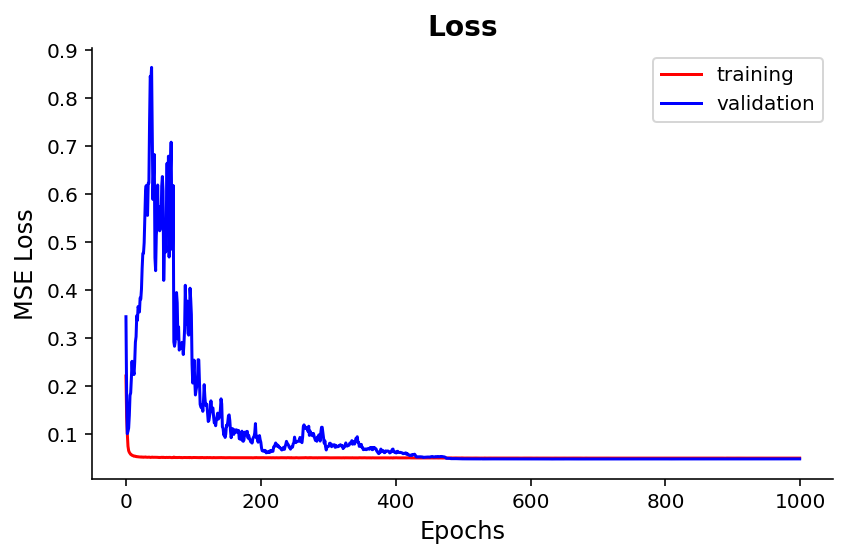

<Figure size 432x288 with 0 Axes>

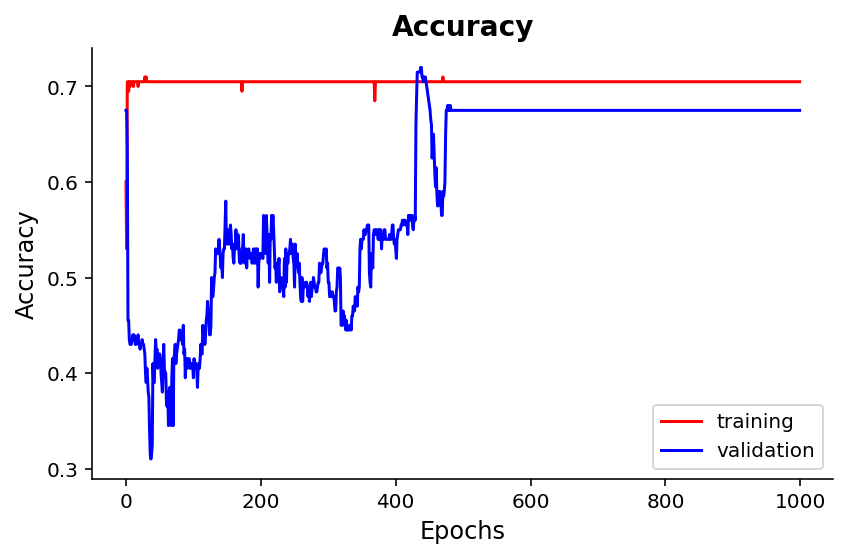

<Figure size 432x288 with 0 Axes>

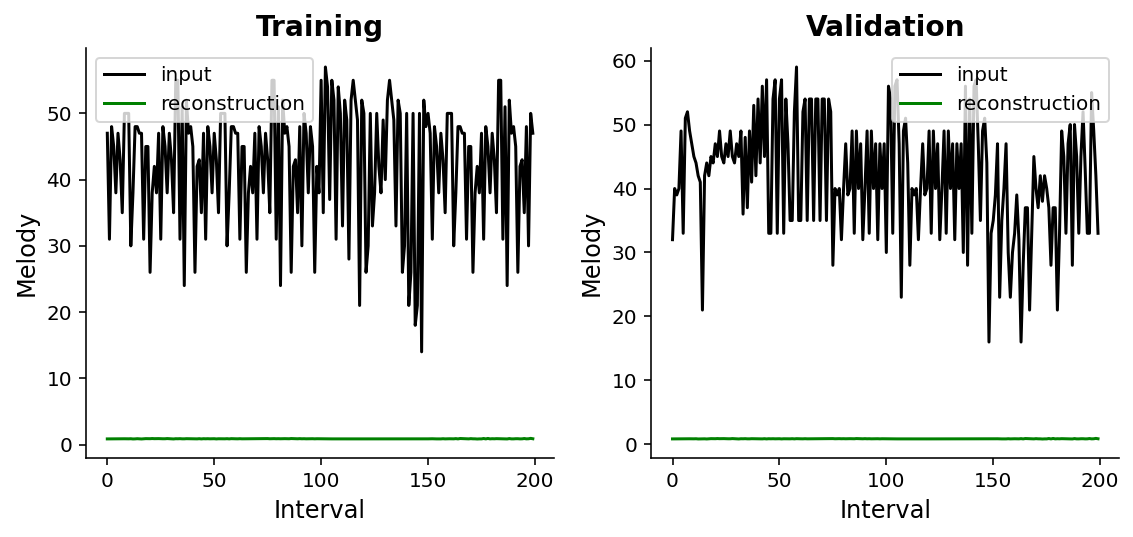

<Figure size 432x288 with 0 Axes>

In [55]:
### ===== Train Model for Melody using MSELoss ===== ###

seed_model = np.random.randint(0,999999999)
seed_model = 527758681 
torch.manual_seed(seed_model)

model = mdl.cnn_varautoencoder(1, song_len//200, classes_j, std=1.0)
model.float()
model.to(device)

try: 
    model_melody, train_losses_m, val_losses_m, train_acc_m, val_acc_m = train_model(model, device, mdl_name+'_MSE',
               X_train_joint, X_val_joint,
               learning_rate, [seed_load, seed_model], 1000,
               eepoch=100,
               lda0=1, lda1=0, lda2=1,
               train_losses=[], val_losses=[], train_acc=[], val_acc=[],
               save=True, load=False)
    
    vis.plot_train_val_loss(train_losses_m, val_losses_m, './figures/{}_MSE_loss.png'.format(mdl_name), ylabel='MSE Loss')
    vis.plot_train_val_loss(train_acc_m, val_acc_m, './figures/{}_MSE_acc.png'.format(mdl_name), ylabel='Accuracy', title='Accuracy')
    _ = vis.plot_train_val_sample(model_melody, X_train_joint[0], X_val_joint[0], './figures/{}_MSE_sample.png'.format(mdl_name))
    
except KeyboardInterrupt:
    print('Training terminated.')

Epoch: 0	 TLoss: 486.232920	 VLoss: 229.334842	 TACC: 0.04	 VACC: 0.02
Epoch: 100	 TLoss: 143.514919	 VLoss: 183.017316	 TACC: 0.04	 VACC: 0.06
Epoch: 200	 TLoss: 225.353566	 VLoss: 639.859728	 TACC: 0.06	 VACC: 0.03
Epoch: 300	 TLoss: 325.830037	 VLoss: 1668.362362	 TACC: 0.07	 VACC: 0.03
Epoch: 400	 TLoss: 683.008896	 VLoss: 4274.961736	 TACC: 0.06	 VACC: 0.01
Epoch: 500	 TLoss: 1361.614206	 VLoss: 10723.086015	 TACC: 0.09	 VACC: 0.02
Epoch: 600	 TLoss: 2705.925134	 VLoss: 26734.720357	 TACC: 0.10	 VACC: 0.02
Epoch: 700	 TLoss: 6752.293127	 VLoss: 71199.667729	 TACC: 0.07	 VACC: 0.03
Epoch: 800	 TLoss: 18986.434279	 VLoss: 178628.516690	 TACC: 0.09	 VACC: 0.01
Epoch: 900	 TLoss: 36825.942812	 VLoss: 475526.000327	 TACC: 0.07	 VACC: 0.01
Epoch: 1000	 TLoss: 96018.517698	 VLoss: 1194067.330670	 TACC: 0.07	 VACC: 0.01
Epoch: 1100	 TLoss: 79179.948707	 VLoss: 1256063.653188	 TACC: 0.10	 VACC: 0.02
Epoch: 1200	 TLoss: 67938.707739	 VLoss: 1178827.254879	 TACC: 0.12	 VACC: 0.03
Epoch: 1300

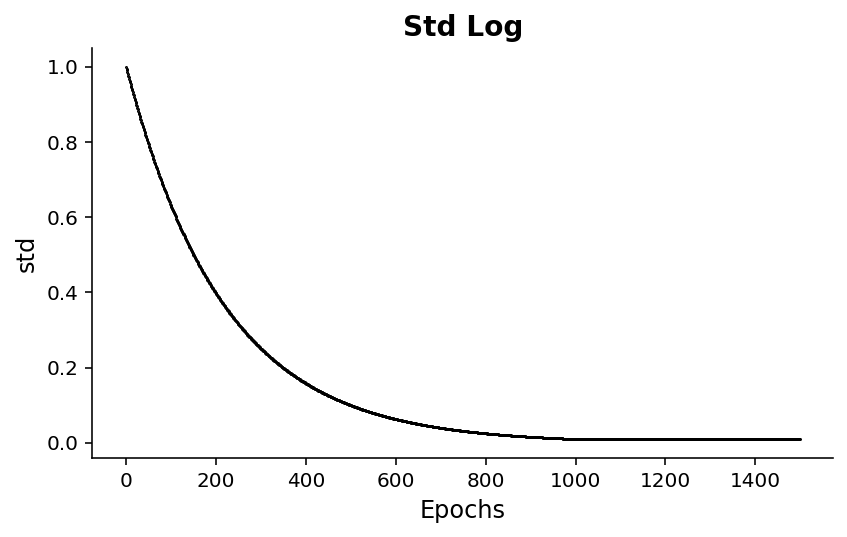

<Figure size 432x288 with 0 Axes>

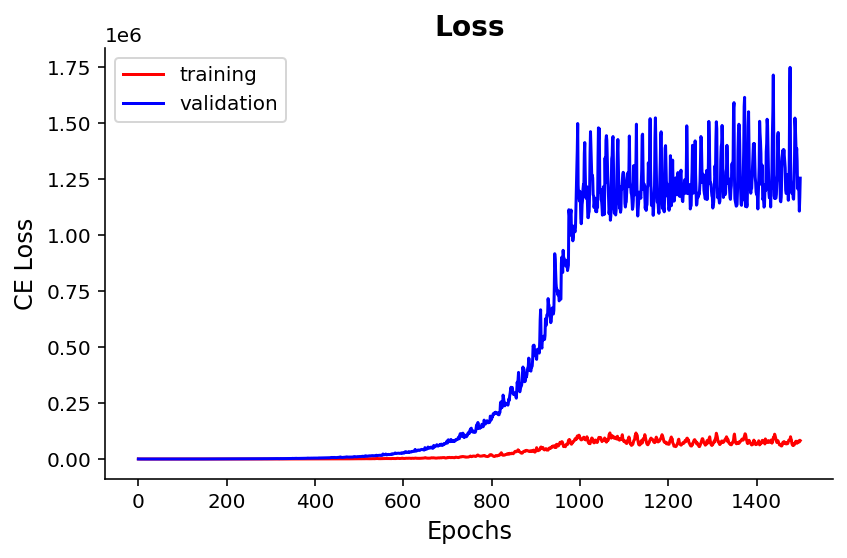

<Figure size 432x288 with 0 Axes>

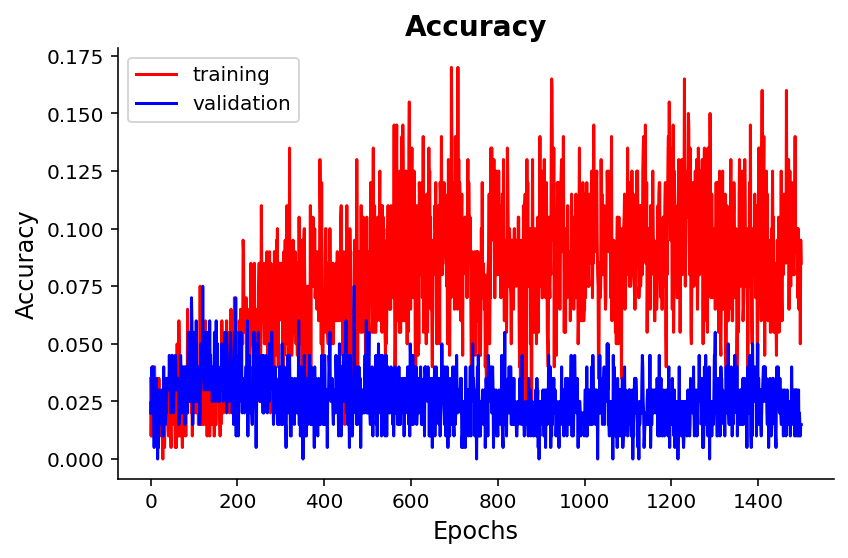

<Figure size 432x288 with 0 Axes>

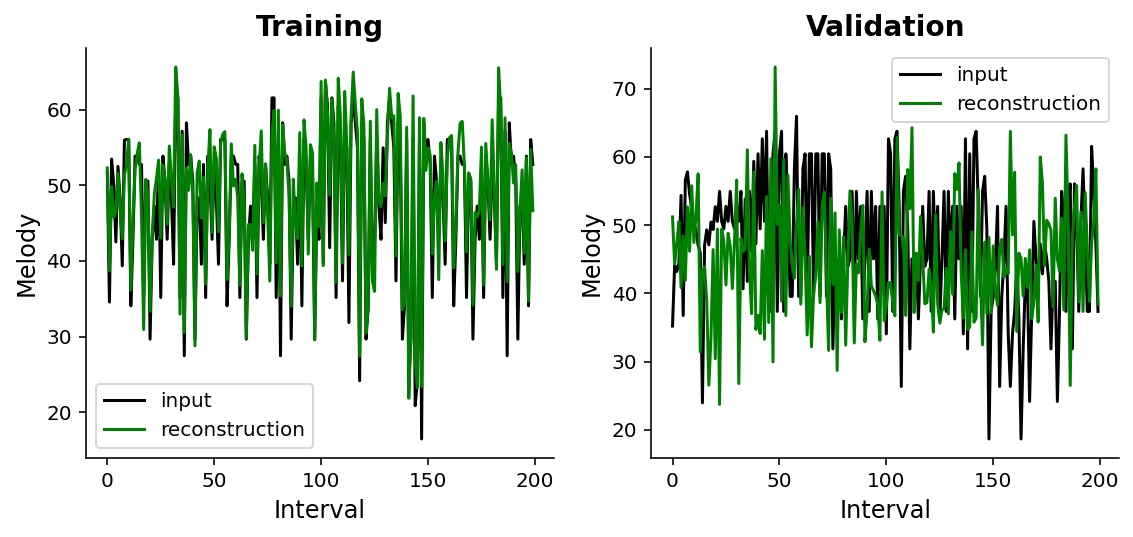

<Figure size 432x288 with 0 Axes>

In [62]:
### ===== Train Model for Melody using CELoss ===== ###

seed_model = np.random.randint(0,999999999)
seed_model = 527758681 
torch.manual_seed(seed_model)

model = mdl.cnn_varautoencoder(1, song_len//200, classes_j, std=1.0)
model.float()
model.to(device)

try: 
    stdlog = np.append(np.geomspace(1, 0.01, 1000), np.ones(500)*0.01)
    model_melody, train_losses_m, val_losses_m, train_acc_m, val_acc_m = train_model(model, device, mdl_name+'_CE',
                   X_train_joint, X_val_joint,
                   learning_rate, [seed_load, seed_model], 1500,
                   eepoch=100,
                   lda0=0, lda1=1, lda2=1,
                   stdlog=stdlog,
                   train_losses=[], val_losses=[], train_acc=[], val_acc=[],
                   save=True, load=False)
    
    vis.plot_stdlog(stdlog, './figures/{}_CE_stdlog.png'.format(mdl_name))
    vis.plot_train_val_loss(train_losses_m, val_losses_m, './figures/{}_CE_loss.png'.format(mdl_name), ylabel='CE Loss')
    vis.plot_train_val_loss(train_acc_m, val_acc_m, './figures/{}_CE_acc.png'.format(mdl_name), ylabel='Accuracy', title='Accuracy')
    _ = vis.plot_train_val_sample(model_melody, X_train_joint[0], X_val_joint[0], './figures/{}_CE_sample.png'.format(mdl_name))
    
except KeyboardInterrupt:
    print('Training terminated.')